Multivariate Kalman Filter With Rolling Window Example

by jayzer

This demonstration showcases the application of the Kalman Filter for smoothing noisy time-series data using the pykalman library in Python. We'll simulate data with noise, outliers, and missing values.

Initial Training and Rolling Update

The initial 100 samples establish a starting point for the Kalman filter. The filter is trained on these samples, providing an initial estimate of the system's state. Subsequently, the rolling window leverages the smoothed data to retrain the filter for the next window, enabling adaptation. Each window's smoothed data acts as training data for the next.

Overview of Steps:

1. Data Simulation: We generate synthetic time-series data with added noise, extreme values (outliers), and missing data points to mimic real-world scenarios.

2. Initial Data Imputation: A basic imputation technique is used to fill initial missing values, allowing the Kalman Filter to be initialized.

3. Kalman Filter Initialization: The Kalman Filter is set up and trained on an initial portion of the data. Parameters are adjusted for robustness against extreme values.

4.0, 5.0 Rolling Window Training and Smoothing: The filter is applied using a rolling window approach. This allows the filter to adapt to changes in the data over time. The filter is retrained on each window using the previously smoothed data.

6. Visualization: Results are visualized, comparing the true underlying data, the noisy observations, and the smoothed output from the Kalman Filter.

In [1]:
!pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 8.7 MB/s eta 0:00:00


In [22]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# For reproducibility
np.random.seed(32)

###############################################
# Step 1: Simulate Data with Noise and Extremes
###############################################

# Define data dimensions
n_timesteps = 1000
n_variables = 10

# Simulate the underlying true state as an AR(1) process to keep values bounded
phi = 0.95  # autoregressive coefficient (less than 1 to ensure stationarity)
true_state = np.zeros((n_timesteps, n_variables))
true_state[0] = np.random.randn(n_variables)
for t in range(1, n_timesteps):
    true_state[t] = phi * true_state[t-1] + np.random.randn(n_variables)

# Create variable-specific noise levels (from 0.5 to 2.0)
noise_std = np.linspace(0.5, 2.0, n_variables)

# Generate noisy observations: add variable-specific noise to the true state
observations = true_state + np.random.randn(n_timesteps, n_variables) * noise_std

# Inject extreme (outlier) data points at random: 1% probability per entry,
# where the extreme value is 10 times the current observation value.
extreme_mask = np.random.rand(n_timesteps, n_variables) < 0.01
observations[extreme_mask] *= 10

# Introduce missing values across all time steps (~10% missing per entry)
missing_mask = np.random.rand(n_timesteps, n_variables) < 0.1
observations[missing_mask] = np.nan

# Print head (first 5 rows) for illustration
print("True state head (first 5 rows):")
print(true_state[:5])
print("\nObservations head (first 5 rows):")
print(observations[:5])


True state head (first 5 rows):
[[-0.34889445  0.98370343  0.58092283  0.07028444  0.77753268  0.58195875
   1.47179053  1.66318101 -0.26117712 -0.68867681]
 [-1.02637299  2.87494172  2.35729188  0.52308407  0.163844    0.66704131
   2.91178177  1.9311538  -0.33705148  0.26271126]
 [-0.46940922  1.91592353  2.62857824  0.0719674   0.19527495  0.10572532
   2.255889    0.94631096  0.76742583  0.92296796]
 [-1.51325579  3.03817733  5.86086187 -0.76388438 -0.15483717 -1.75813249
   2.14391762  1.25056989  2.25056338  0.19634542]
 [-0.49953529  2.20485375  5.3667207  -0.7431788  -1.93500744 -2.52196609
   0.40841843  2.15503914  2.19115081  0.47624108]]

Observations head (first 5 rows):
[[ 0.5663194   1.52327734 -0.51634348 -0.29637973  0.09657148  2.97267028
  -1.66009339  3.03625299  0.27010595 -2.86927563]
 [-0.6954826   2.4539482   4.28585712 -0.27669679  1.64239308  2.45926596
   3.14510837  1.29130228  0.7211298   2.36867964]
 [-0.78498902  0.45600084         nan         nan  0.5727

In [23]:
###############################################
## Step 2: Data Imputation on the First 100 Rows Using Chained ffill() and bfill()
###############################################

# Keep a copy of the observations before imputation for later comparison
data_observed = observations.copy()

# Create a DataFrame from the first 100 rows of the observations
df_first100 = pd.DataFrame(data_observed[:100])

# Fill missing values using chained forward-fill then backward-fill
df_first100 = df_first100.ffill().bfill()

# Update the first 100 rows of our observations with the imputed data
data_filled = data_observed.copy()
data_filled[:100] = df_first100.values

# Print the imputed data head (first 5 rows of the first 100)
print("Imputed data (first 5 rows of initial 100):")
print(df_first100.head())


Imputed data (first 5 rows of initial 100):
          0         1         2         3         4         5         6  \
0  0.566319  1.523277 -0.516343 -0.296380  0.096571  2.972670 -1.660093   
1 -0.695483  2.453948  4.285857 -0.276697  1.642393  2.459266  3.145108   
2 -0.784989  0.456001  4.285857 -0.276697  0.572726 -0.898446  1.074379   
3 -0.754052  0.456001  4.285857 -1.446339  1.765878 -0.898446  2.061261   
4  0.100494  3.013397  5.520687 -1.680255 -2.131721 -1.377205  2.418666   

          7         8         9  
0  3.036253  0.270106 -2.869276  
1  1.291302  0.721130  2.368680  
2  2.542551  4.508056 -0.458264  
3  3.657164  3.015131 -1.928138  
4  3.657164  0.903879 -1.928138  


In [24]:
###############################################
##Step 3: Initial Kalman Filter Training, Smoothing on First 100 Rows
###############################################

# Set the number of EM iterations
n_em_iter = 10

# Initialize the Kalman Filter (state and observation dimensions are both n_variables)
kf = KalmanFilter(n_dim_obs=n_variables, n_dim_state=n_variables)

# Train (tune) the Kalman Filter on the filled data for the first 100 rows
kf = kf.em(data_filled[:100], n_iter=n_em_iter)

#set covariance adjustment factors for the initial samples
dynamic_noise_factor = 5 #factor for adjusting transition_covariance
inflation_factor = 20 #factor for adjusting observation_covariance

# Adjust process noise covariance (Q) to make the filter trust its predictions more
kf.transition_covariance *= dynamic_noise_factor # Increase Q to reduce sensitivity to extreme observations

# Inflate the observation noise covariance (R) to down-weight extreme observations.
# This tells the filter that the observations are noisier than estimated.
kf.observation_covariance *= inflation_factor

# Before smoothing, mask invalid values (NaN) from the original observed data.
observed_initial = np.ma.masked_invalid(data_observed[:100])

print("observed_initial, first five with blanks:")
print(observed_initial[:5])

# Smooth the observed (masked) data from the first 100 rows
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(observed_initial)
smoothed_results = smoothed_state_means

# Print the head of the smoothed states for the initial block
print("Smoothed state means (first 5 rows of initial 100):")
print(smoothed_results[:5])


observed_initial, first five with blanks:
[[0.5663194037447987 1.523277337459483 -0.5163434755768139
  -0.2963797317696643 0.09657147552471412 2.9726702846580766
  -1.6600933891259986 3.0362529913246155 0.2701059480340274
  -2.869275630264882]
 [-0.6954826011644502 2.4539481971098476 4.285857120738646
  -0.27669678563036093 1.6423930773579507 2.459265960897664
  3.145108365861721 1.29130228086976 0.7211297978685663 2.368679636411758]
 [-0.7849890182737622 0.4560008351537841 -- -- 0.5727263022811813
  -0.8984463687719558 1.074378617577405 2.5425514365300517
  4.508055950680453 -0.4582637814649497]
 [-0.7540518828485577 -- -- -1.4463394498536821 1.765878464938887 --
  2.061261166061941 3.6571644688892997 3.0151305593392426
  -1.928138183774697]
 [0.10049426086518454 3.013396538697009 5.5206874018800836
  -1.6802551097719487 -2.131720785623828 -1.3772050490168106
  2.4186656657658405 -- 0.9038791850592334 --]]
Smoothed state means (first 5 rows of initial 100):
[[ 0.16652796  1.54498319  

In [25]:
###############################################
##Step 4 & 5: Rolling Window Training and Smoothing
###############################################

window_size = 100

#set covariance adjustment factors for the samples trained on smoothed data
dynamic_noise_factor = 2 #factor for adjusting transition_covariance
inflation_factor = 3 #factor for adjusting observation_covariance

# Iterate through the remaining data in windows of 100 rows
for start in range(window_size, n_timesteps, window_size):
    end = start + window_size

    # Retrain the Kalman Filter on the most recent 100 smoothed data
    training_window = smoothed_results[-window_size:]
    #kf = KalmanFilter(n_dim_obs=n_variables, n_dim_state=n_variables)
    kf = kf.em(training_window, n_iter=n_em_iter)

    # Adjust process noise covariance (Q) to make the filter trust its predictions more
    kf.transition_covariance *= dynamic_noise_factor  # Increase Q to reduce sensitivity to extreme observations

    # Inflate the observation noise covariance for robust smoothing:
    kf.observation_covariance *= inflation_factor

    # Mask invalid values in the current window before smoothing
    window_observed = np.ma.masked_invalid(data_observed[start:end])

    # Smooth the current window using the retrained filter
    smoothed_window, _ = kf.smooth(window_observed)
    smoothed_results = np.vstack((smoothed_results, smoothed_window))

    # For illustration: print a head of the current smoothed window (first 3 rows)
    print(f"\nSmoothed state means for window starting at {start} (first 3 rows):")
    print(smoothed_window[:3])

print("\nRolling window training and smoothing complete.")
print("Final smoothed data shape:", smoothed_results.shape)



Smoothed state means for window starting at 100 (first 3 rows):
[[ 0.22331882  1.51016029 -6.5333323  -0.56168584  0.28382382  2.86748319
   0.87663735  1.34828279  1.10789572 -0.26746705]
 [ 1.92762147  0.5128118  -6.71091195  2.92171598  1.60885021  2.98083554
   4.20939114 -2.56971004  0.82149416 -1.01289799]
 [ 1.95166502  0.52373722 -6.37494164  3.10253444  1.53604269  2.75454817
   4.09040491 -2.91566111  0.71362713 -1.19810003]]

Smoothed state means for window starting at 200 (first 3 rows):
[[ 0.23998218  1.48495195 -2.01139429 -0.20272755  0.35966934  2.44197749
   0.46654255  2.12237661  0.86554631 -0.7454311 ]
 [ 0.04346316  1.14074606 -1.91881081  0.48555529  0.77396398  2.29642746
  -2.07091376  2.15872847  1.27008752  1.5088168 ]
 [-0.15305586  0.79654018 -1.82622733  1.17383814  1.18825862  2.15087744
  -4.60837006  2.19508032  1.67462873  3.76306469]]

Smoothed state means for window starting at 300 (first 3 rows):
[[ 0.23941468  1.47695978 -1.967283   -0.16541529  0.

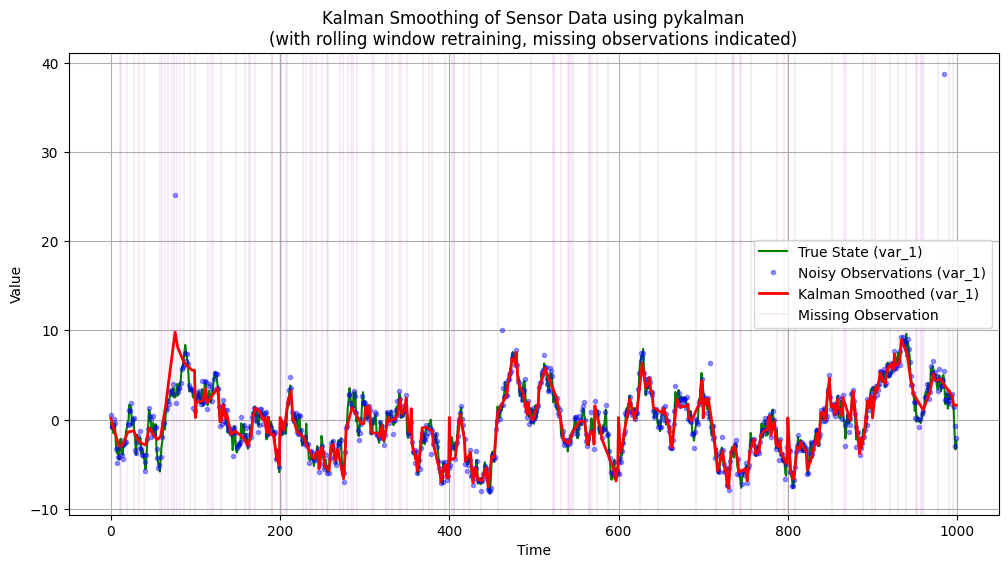

In [26]:
###############################################
# Step 6: Visualization for a Single Variable (e.g., var_1)
###############################################

import pandas as pd

# Create a time index
time_index = np.arange(n_timesteps)

# Construct DataFrames from the arrays for easier plotting and labeling.
# Using column names var_1, var_2, ..., var_10.
df_true = pd.DataFrame(true_state, index=time_index,
                       columns=[f'var_{i+1}' for i in range(n_variables)])
df_obs = pd.DataFrame(observations, index=time_index,
                      columns=[f'var_{i+1}' for i in range(n_variables)])
df_smoothed = pd.DataFrame(smoothed_results, index=time_index,
                           columns=[f'var_{i+1}' for i in range(n_variables)])

# For the noisy observations, remove the most extreme points (max and min) for better scaling.
# Option 1: Remove the single maximum and minimum values.
var1_series = df_obs['var_1']
max_val = var1_series.max()
min_val = var1_series.min()
filtered_obs = var1_series[(var1_series != max_val) & (var1_series != min_val)]

# Plotting the true state, the filtered noisy observations, and the Kalman-smoothed results.
plt.figure(figsize=(12, 6))
plt.plot(df_true.index, df_true['var_1'], 'g-', label='True State (var_1)')
plt.plot(filtered_obs.index, filtered_obs.values, 'bo', label='Noisy Observations (var_1)', markersize=3, alpha=0.4)
plt.plot(df_smoothed.index, df_smoothed['var_1'], 'r-', lw=2, label='Kalman Smoothed (var_1)')

# Identify the time indices where the original observation was missing (NaN)
missing_indices = df_obs.index[df_obs['var_1'].isna()]

# Plot a vertical dashed line at each missing observation time point.
for i, mi in enumerate(missing_indices):
    if i == 0:
        plt.axvline(x=mi, color='purple', linestyle='-', linewidth=0.1, label='Missing Observation')
    else:
        plt.axvline(x=mi, color='purple', linestyle='-', linewidth=0.1)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Kalman Smoothing of Sensor Data using pykalman\n(with rolling window retraining, missing observations indicated)')
plt.legend()
plt.grid(True)
plt.show()

# Additional tip: if you prefer not to remove data points but simply adjust the scale,
# you can set the y-axis limits (e.g., using plt.ylim(lower_bound, upper_bound))


In this demonstration, we've explored how the Kalman Filter, implemented using the pykalman library, can be effectively used to smooth noisy time-series data and handle challenges like outliers and missing values. By incorporating techniques like rolling window training, we can enhance the filter's performance and adaptability.

The Kalman Filter's ability to estimate the underlying true state of a system from noisy observations makes it a valuable tool in various fields. While this demonstration focused on a specific scenario, the principles and techniques illustrated here can be extended and applied to a wide range of time-series analysis tasks, offering a robust and flexible approach to data smoothing and state estimation using pykalman.